In [76]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

#from astropy.modeling.models import Gaussian1D
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel, convolve_fft

import emcee
import corner
import pickle

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['savefig.transparent'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.edgecolor'] = 'white'

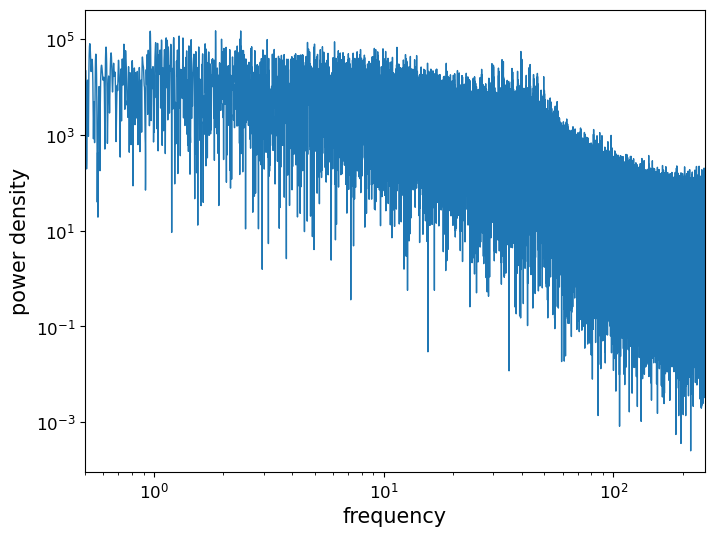

In [4]:
# start by taking an example powerspectrum from my set of stars
# powerspec = pd.read_csv('../data/hpfiltered_LCs/KIC3347458_PS.csv')
powerspec = pd.read_csv('../data/bgfitting_PSDs/KIC3347458_PS.csv')


# eff_obs_time = len(lightcurve) * 1800e-6 #this is in megaseconds, which will inverse to muHz
# print(eff_obs_time)
# eff_obs_time = 110.079 # for this star specifically
powerdensity = powerspec['power']#*eff_obs_time #convert to power DENSITY
frequency = powerspec['freq']

# plt.plot(powerspec['freq'],powerspec['power'])
plt.plot(frequency,powerdensity)
plt.xlabel('frequency')
plt.ylabel('power density')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.5,250)
plt.show()

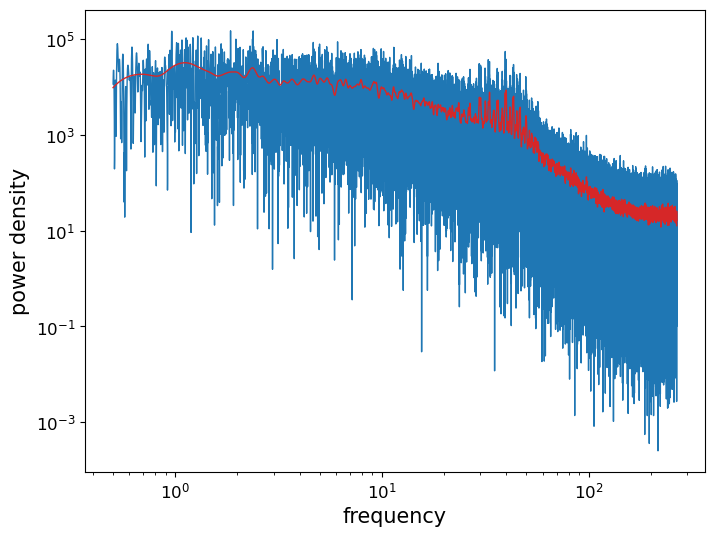

In [5]:
## probably I should manipulate the data actually
## at least slice it at some minimum
powerdensity = powerdensity[frequency>0.5]
frequency = frequency[frequency>0.5]

## should I also smooth this??
powerdensity_smooth = convolve(powerdensity, Gaussian1DKernel(100))

plt.plot(frequency,powerdensity)
plt.plot(frequency,powerdensity_smooth,color='tab:red')
plt.xlabel('frequency')
plt.ylabel('power density')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.5,250)
plt.show()

In [6]:
## so the first thing I need to do is generate the model for the data

# def harvey_model(nu, nu_char, amp):
#     numer = 4*amp**2*tau
#     denom = (1 + (2*np.pi*tau*nu)**2 + (2*np.pi*tau*nu)**4)
#     return numer/denom

def harvey_model(nu,amp,nu_char):
    numer = amp
    denom = 1 + (nu/nu_char)**2 + (nu/nu_char)**4
    return numer/denom

def power_excess(nu,amplitude,mu,sigma):
    return amplitude*np.exp(-(1/2)*((nu-mu)/sigma)**2)

def background_model(nu, amp1, nu_char1, amp2, nu_char2, whitenoise):#, amplitude, mu, sigma):
    return whitenoise + harvey_model(nu,amp1,nu_char1) + harvey_model(nu,amp2,nu_char2)#+ power_excess(nu,amplitude,mu,sigma)

def background_model_w_power_excess(nu, amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma):
    return background_model(nu, amp1, nu_char1, amp2, nu_char2, whitenoise) + power_excess(nu,amplitude,mu,sigma)


In [7]:
## then I need to generate a (log) likelihood function
## luckily I have one in my widget already
# def minus_log_likelihood(theta, freq, power):
#     amp, cen, wid, bg = theta
#     model = lorentzian(freq,amp,cen,wid) + bg
#     return np.sum(np.log(model) + power/model)
## since the errors in fourier space are NOT normally distributed
## generally its logL = sum(log(model)+data/model) summed over all the data points

def log_likelihood(theta, freq, power): #theta MUST be an array-like of parameters to optimize
    amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma = theta
#     model = background_model_two_harveys(freq, amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma)
    model = background_model_w_power_excess(freq, amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma)
    return -np.sum(np.log(model) + power/model)

def minus_log_likelihood(theta, freq, power): 
    return -log_likelihood(theta, freq, power)

In [8]:
# pysyd_guess = np.array([6170.5631,   1/0.034685678,  27536.265,   1/0.24321178,    20, 100, 40, 20])
pysyd_guess = np.array([27536, 4, 6170, 28, 20, 100, 40, 20])
xmin= np.array([0, 0, 0, 0, 0, 0, 20, 0])
xmax= np.array([1e5,250,1e5,250,1e3,1e6,60,20])

In [9]:
bnds = np.c_[(xmin,xmax)]

In [10]:
soln = minimize(minus_log_likelihood, pysyd_guess, args=(frequency,powerdensity_smooth), bounds=bnds)
#         res = minimize(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
#                        args=(freq_region,power_region), bounds=bnds)
soln.x

array([2.75316409e+04, 5.08202883e+00, 6.23950464e+03, 3.04115202e+01,
       1.97979554e+01, 1.58089756e+03, 4.00813342e+01, 6.73296572e+00])

In [11]:
## this is where we enforce a prior - or some bounds

# # theta, xmin, xmax are both 1d-arrays
# def log_prior(theta,xmin,xmax):
#     amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma = theta
#     if  np.sum((theta<xmin) | (theta>xmax)) or amp1<amp2 or nu_char1>nu_char2 or whitenoise>amp2: 
#         return -np.inf
#     else:
#         return 0.0 #-np.log((theta*np.log(xmax/xmin))) #this log thing doesn't work for some reason

# def log_prior(theta, freq, power):
#     amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma = theta
#     if (0.0<amp1<1e5) and (0.0<nu_char1<250) and (0.0<amp2<1e5) and (0.0<nu_char2<250) and \
#        (0.0<whitenoise<1e3) and (0.0<amplitude<1e6) and (40*0.5<mu<40*1.5) and (0<sigma<20) and \
#         amp1>amp2 and nu_char1<nu_char2 and whitenoise<amp2:
#         return 0.0
#     return -np.inf

def log_prior(theta, freq, power):
    amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma = theta
    if (0.0<amp1<np.max(power)) and (0.0<nu_char1<np.max(freq)) and \
        (0.0<amp2<np.max(power)) and (0.0<nu_char2<np.max(freq)) and \
        (np.min(power)<whitenoise<1e3) and (0.0<amplitude<np.max(power)) and (40*0.5<mu<40*1.5) and (0<sigma<20) and \
        amp1>amp2 and nu_char1<nu_char2 and whitenoise<amp2:
        return 0.0
    return -np.inf

# def log_prior(theta, freq, power):
#     amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, numax, sigma = theta
#     if (np.abs(amp1-np.average(power[freq<5]))<1e4) and (0.0<nu_char1<np.max(freq)) and \
#         (0.0<amp2<np.max(power)) and (0.0<nu_char2<np.max(freq)) and \
#         (np.abs(whitenoise-np.average(power[freq>1e3]))<1e3) and (0.0<amplitude<np.max(power)) and \
#         (40*0.5<numax<40*1.5) and (0<sigma<20) and \
#         amp1>amp2 and nu_char1<nu_char2 and whitenoise<amp2:
#         return 0.0
#     return -np.inf

In [12]:
## then I would use the prior and the likelihood to do a probability
def log_probability(theta, freq, power):#, xmin, xmax):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
    return log_likelihood(theta, freq, power) + log_prior(theta, freq, power)#, xmin, xmax)

In [13]:
## now for the emcee initialization
## some randomly sampled guesses 
## (this one has 32 walkers)
## I think this is where you would use the solar scaling - maybe I can just use the solar values?
## for now I am using the old pysyd fitting values :) 
# pysyd_guess = np.array([6170.5631,   1/0.034685678,  27536.265,   1/0.24321178,    20, 100, 40, 20])

# pos = pysyd_guess + 1e2 * np.random.randn(32, 5) # this needs work!!
# pos = pysyd_guess*np.random.rand(30,8)
pos = soln.x*np.random.rand(30,8)
# pos = np.zeros((32, 5))
# for i in range(0,5):
# #     print(np.log10(pysyd_guess[i]))
#     pos[:,i] = 10**(np.log10(pysyd_guess[i])-1)*np.random.randn(32)+pysyd_guess[i]
nwalkers, ndim = pos.shape
print(nwalkers,ndim)
# print(pos)

30 8


In [14]:
## then put those into the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(frequency, powerdensity)#, xmin, xmax)
)

In [15]:
## now we pray that it works??
sampler.run_mcmc(pos, 1000, progress=True);

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/ccra8514/anaconda3/envs/emcee_env/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ccra8514/anaconda3/envs/emcee_env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1000/1000 [07:10<00:00,  2.32it/s]


In [ ]:
# with open('../data/emcee_pickles/KIC3347458.pkl', 'rb') as f:
#     samples = pickle.load(f) # deserialize using load()

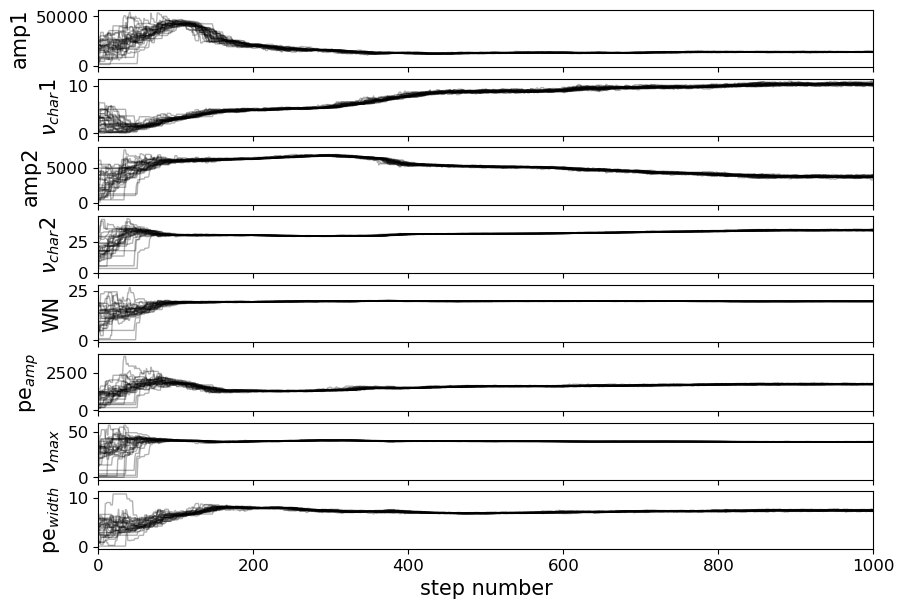

In [16]:
## look at the convergence?
fig, axes = plt.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['amp1', r'$\nu_{char}$1', 'amp2', r'$\nu_{char}$2', 'WN', r'pe$_{amp}$',r'$\nu_{max}$',r'pe$_{width}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
flat_samples = sampler.get_chain(discard=800, thin=15, flat=True)
print(flat_samples.shape)

(390, 8)


In [77]:
samples = sampler.get_chain()
with open('../data/emcee_pickles/KIC3347458.pkl', 'wb') as f:
    pickle.dump(samples, f)
    f.close()
    
# with open('sampler.pkl', 'rb') as f:
#     samples = pickle.load(f) # deserialize using load()

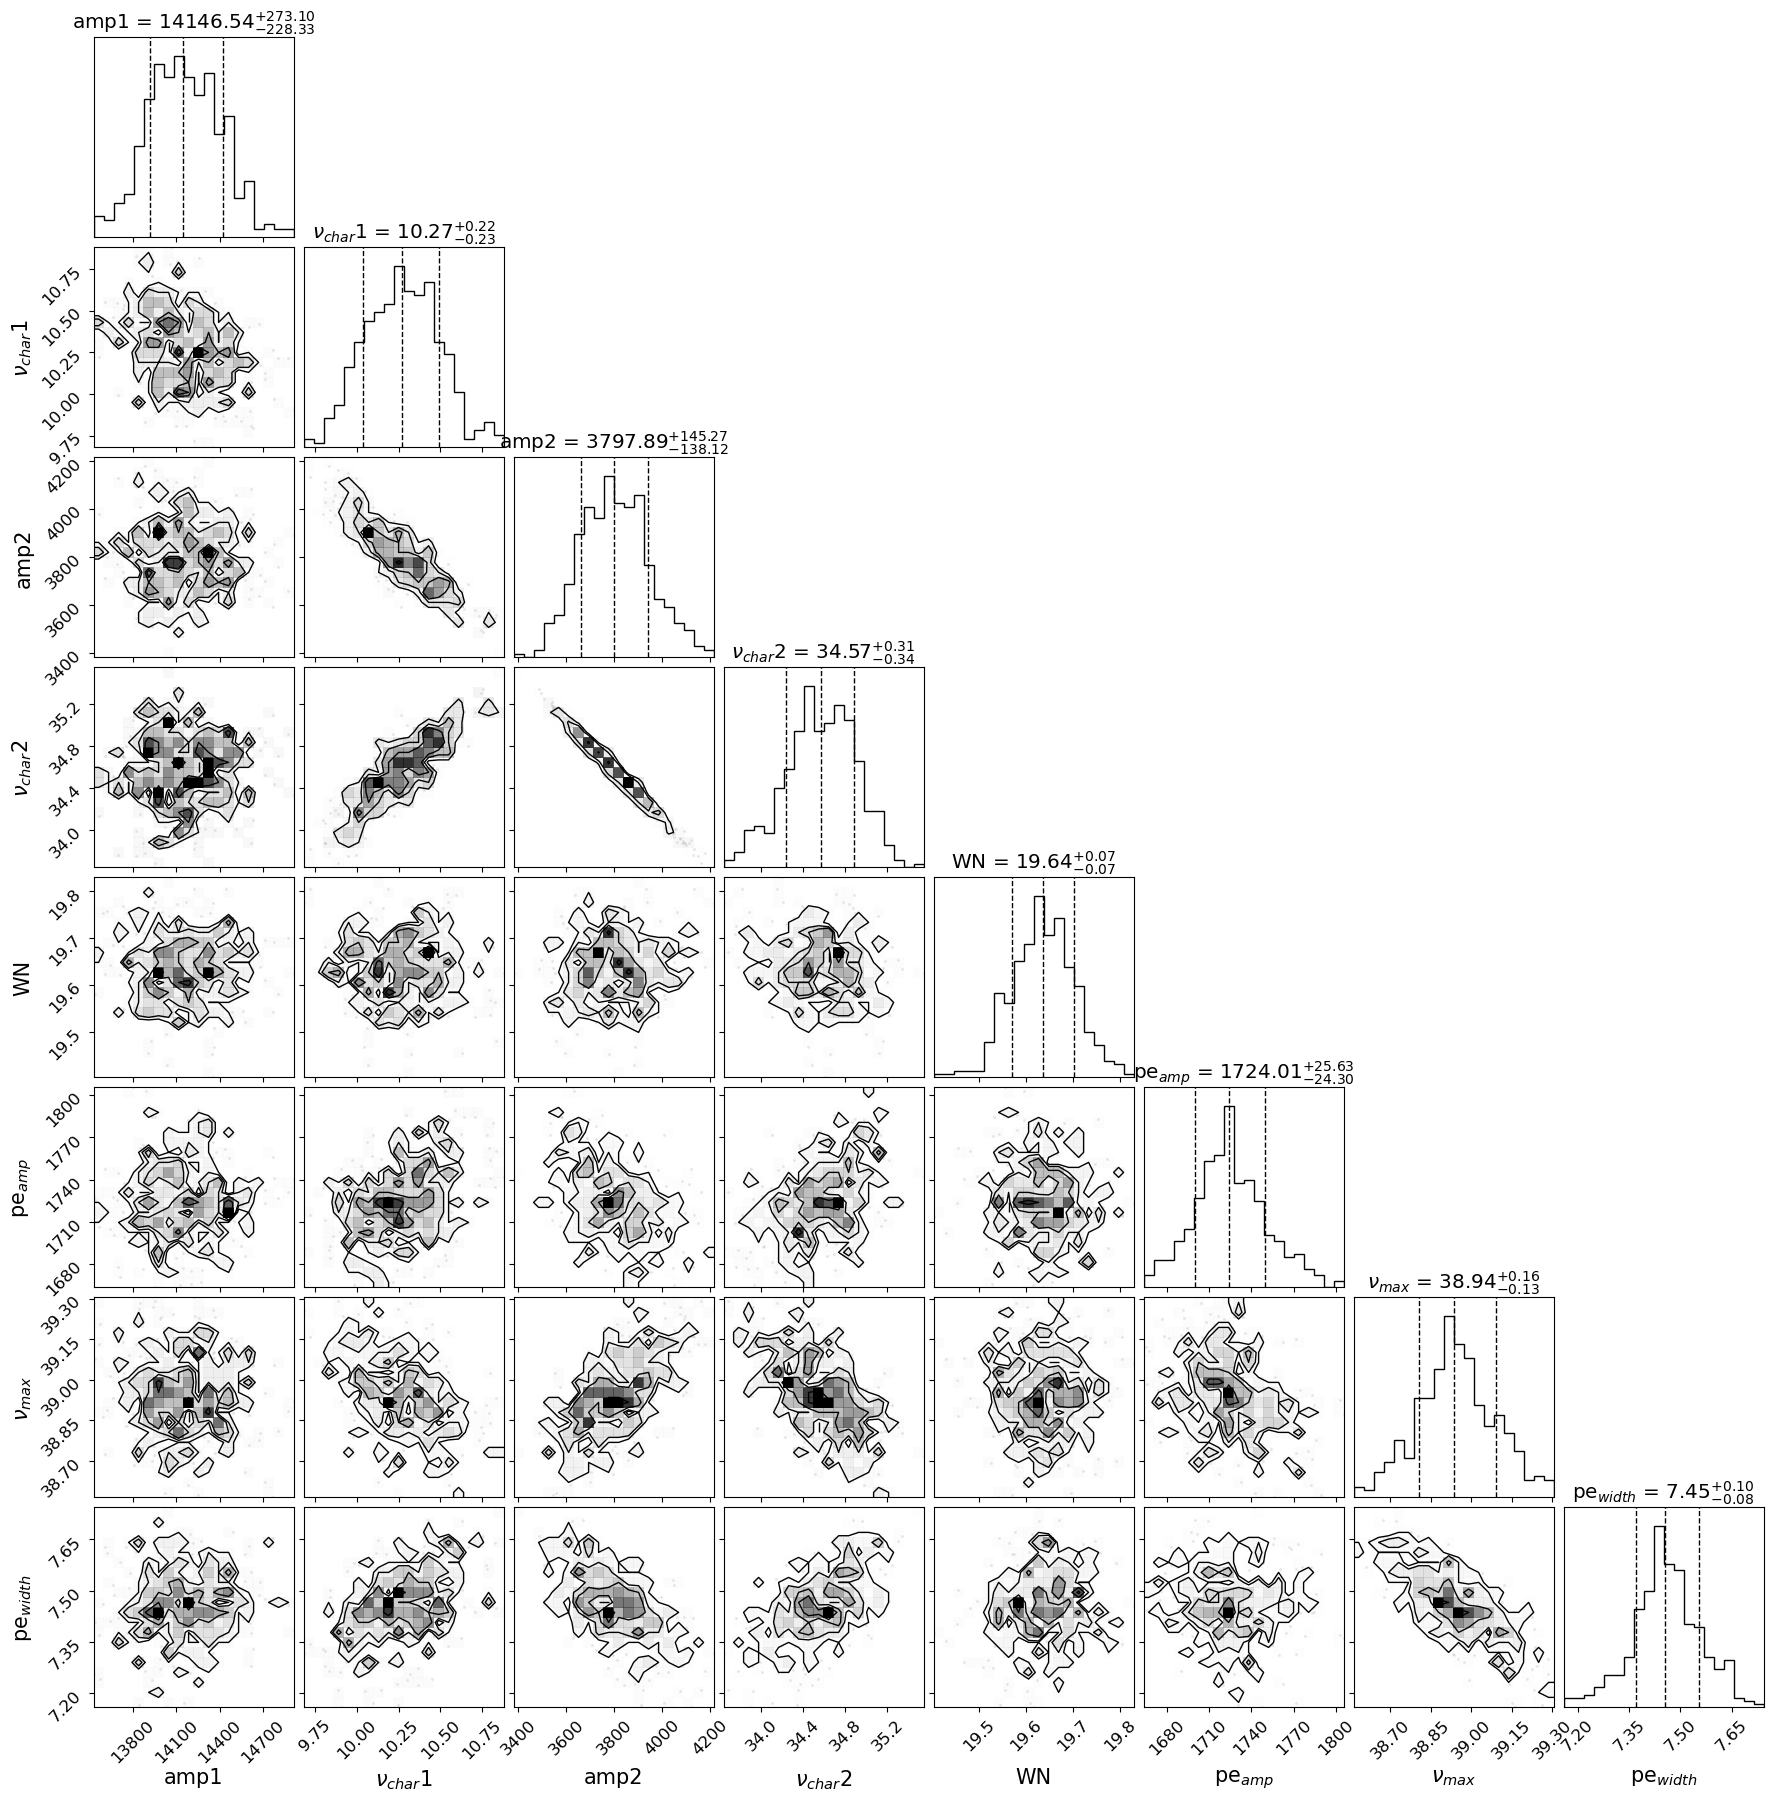

In [18]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True#, truths=pysyd_guess
);

In [118]:
emcee_soln = []
emcee_errs = []
for i in range(0,len(flat_samples[0])):
    emcee_soln.append(corner.quantile(flat_samples[:,i], 0.5)[0])
    emcee_errs.append(np.average(np.abs(corner.quantile(flat_samples[:,i], [0.16, 0.84])-\
                                        corner.quantile(flat_samples[:,i], 0.5)[0])))
# emcee_soln = flat_samples[-1]
str_list = np.array(['amp1','nu_char1','amp2','nu_char2','wn','pe_amp','numax','pe_width'])
emcee_full_soln = np.c_[(emcee_soln,emcee_errs)]
emcee_df = pd.DataFrame(emcee_full_soln,index=str_list)
emcee_df.to_csv('../data/emcee_fits/KIC3347458.csv',header=False)

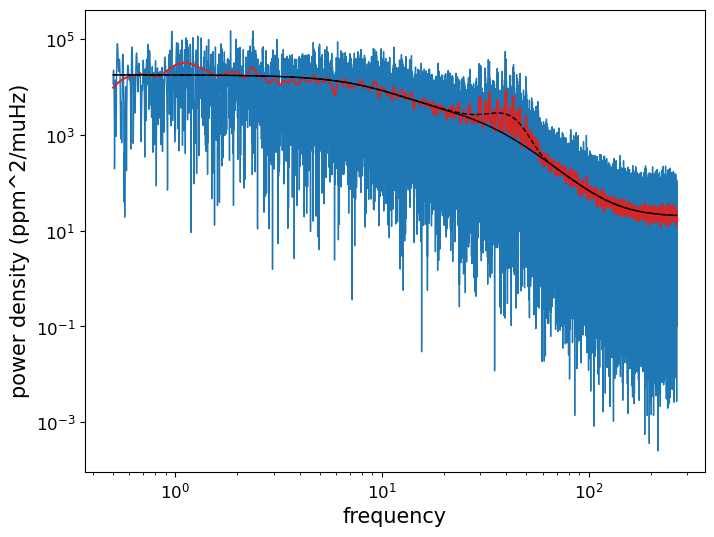

In [103]:
plt.plot(frequency, powerdensity, color='tab:blue')
plt.plot(frequency, powerdensity_smooth, color='tab:red',linewidth=1.5)
# plt.plot(frequency, background_model_w_power_excess(frequency, *soln.x),color='k',linestyle='--')
plt.plot(frequency, background_model(frequency, *emcee_soln[:5]),color='k')
plt.plot(frequency, background_model_w_power_excess(frequency, *emcee_soln),color='k',linestyle='--')
# plt.plot(frequency[frequency<80], power_excess(frequency[frequency<80], *emcee_soln[-3:]),color='tab:green')
# inds = np.random.randint(len(flat_samples), size=100)
# for ind in inds:
#     sample = flat_samples[ind]
#     plt.plot(frequency, background_model_two_harveys(frequency, *sample), color='k', alpha=0.1)
plt.xlabel('frequency')
plt.ylabel('power density (ppm^2/muHz)')
plt.yscale('log')
plt.xscale('log')
plt.show()

numax fitted: 38.908712939350366
numax smoothed: 41.64307025847779


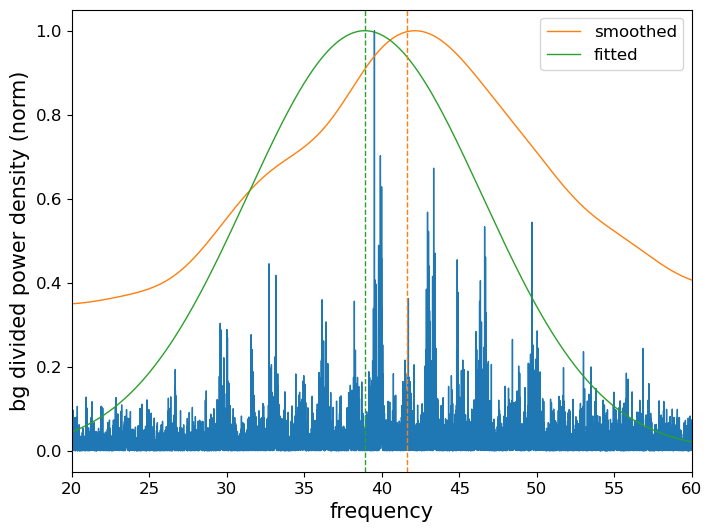

In [74]:
# bg_divided_power = powerdensity/background_model_two_harveys(frequency, emcee_soln[0], emcee_soln[1], emcee_soln[2],
#                                                             emcee_soln[3], emcee_soln[4], 0, 0, 0)
bg_divided_power = powerdensity/background_model(frequency, *emcee_soln[:5])
bg_divided_smooth_power = convolve_fft(bg_divided_power, Gaussian1DKernel(3000))

plt.plot(frequency,bg_divided_power/np.max(bg_divided_power))
plt.plot(frequency,bg_divided_smooth_power/np.max(bg_divided_smooth_power),
         label='smoothed')
# plt.plot(frequency,power_excess(frequency, *emcee_soln[-3:])/np.max(power_excess(frequency, *emcee_soln[-3:])))
# plt.plot(frequency,bg_subtracted_power/np.max(bg_subtracted_power[frequency>25]))
plt.plot(frequency,power_excess(frequency, *emcee_soln[-3:])/np.max(power_excess(frequency, *emcee_soln[-3:])),
         label='fitted')
plt.axvline(emcee_soln[-2],color='tab:green',linestyle='--')
plt.axvline(frequency[np.argmax(bg_divided_smooth_power)],color='tab:orange',linestyle='--')
print('numax fitted:',emcee_soln[-2])
print('numax smoothed:',frequency[np.argmax(bg_divided_smooth_power)])
plt.xlabel('frequency')
plt.ylabel('bg divided power density (norm)')
plt.xlim(20,60)
# plt.ylim(-0.1,1.2)
plt.legend()
plt.show()

In [122]:
emcee_soln = []
emcee_errs = []
for i in range(0,len(flat_samples[0])):
    emcee_soln.append(corner.quantile(flat_samples[:,i], 0.5)[0])
    emcee_errs.append(np.average(np.abs(corner.quantile(flat_samples[:,i], [0.16, 0.84])-\
                                        corner.quantile(flat_samples[:,i], 0.5)[0])))
emcee_soln.append(frequency[np.argmax(bg_divided_smooth_power)])
emcee_errs.append(np.NaN)
# emcee_soln = flat_samples[-1]
str_list = np.array(['amp1','nu_char1','amp2','nu_char2','wn','pe_amp','numax','pe_width','smooth_numax'])
emcee_full_soln = np.c_[(emcee_soln,emcee_errs)]
emcee_df = pd.DataFrame(emcee_full_soln,index=str_list)
emcee_df.to_csv('../data/emcee_fits/KIC3347458.csv',header=False)
emcee_df

,0,1
amp1,14146.542726,250.713272
nu_char1,10.268547,0.226147
amp2,3797.893914,141.693957
nu_char2,34.573502,0.324010
wn,19.635126,0.065669
pe_amp,1724.005127,24.964435
numax,38.936379,0.142422
pe_width,7.453893,0.091652
smooth_numax,41.643070,NaN


# Now to wrap everything together

In [123]:
def harvey_model(nu,amp,nu_char):
    numer = amp
    denom = 1 + (nu/nu_char)**2 + (nu/nu_char)**4
    return numer/denom

def power_excess(nu,amplitude,mu,sigma):
    return amplitude*np.exp(-(1/2)*((nu-mu)/sigma)**2)

def background_model(nu, amp1, nu_char1, amp2, nu_char2, whitenoise):
    return whitenoise + harvey_model(nu,amp1,nu_char1) + harvey_model(nu,amp2,nu_char2)

def background_model_w_power_excess(nu, amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma):
    return background_model(nu, amp1, nu_char1, amp2, nu_char2, whitenoise) + power_excess(nu,amplitude,mu,sigma)

def log_likelihood(theta, freq, power): 
    amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma = theta
    model = background_model_w_power_excess(freq, amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma)
    return -np.sum(np.log(model) + power/model)

def minus_log_likelihood(theta, freq, power): 
    return -log_likelihood(theta, freq, power)

def log_prior(theta, freq, power):
    amp1, nu_char1, amp2, nu_char2, whitenoise, amplitude, mu, sigma = theta
    if (0.0<amp1<np.max(power)) and (np.min(freq)<nu_char1<np.max(freq)) and \
        (0.0<amp2<np.max(power)) and (np.min(freq)<nu_char2<np.max(freq)) and \
        (np.min(power)<whitenoise<1e3) and (0.0<amplitude<np.max(power)) and \
        (np.min(freq)<mu<np.max(freq)) and (0<sigma<20) and \
        amp1>amp2 and nu_char1<nu_char2 and whitenoise<amp2:
        return 0.0
    return -np.inf

def log_probability(theta, freq, power):
    return log_likelihood(theta, freq, power) + log_prior(theta, freq, power)


In [124]:
def run_initial_minimization(freq,power,initial_guess,bnds):
    soln = minimize(minus_log_likelihood, initial_guess, args=(freq,power), bounds=bnds)
    return soln

In [125]:
def run_emcee(freq,power,minimization_guess):
    pos = minimization_guess*np.random.rand(30,8)
    nwalkers, ndim = pos.shape
    print(nwalkers,ndim)
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(freq,power)
    )
    sampler.run_mcmc(pos, 1000, progress=True);
    fig, axes = plt.subplots(8, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ['amp1', r'$\nu_{char}$1', 'amp2', r'$\nu_{char}$2', 'WN', r'pe$_{amp}$',r'$\nu_{max}$',r'pe$_{width}$']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
    #     ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.show()
    return samples,labels,sampler

In [126]:
def plot_fit(freq,power,smooth_power,solution,minimization):
    plt.plot(freq, power, color='tab:blue')
    plt.plot(freq, smooth_power, color='tab:red',linewidth=1.5)
#     plt.plot(freq, background_model_w_power_excess(frequency, *minimization),color='k',linestyle='--')
    plt.plot(freq, background_model(freq, *solution[:5]),color='k')
    plt.plot(freq, background_model_w_power_excess(freq, *solution),color='k',linestyle='--')
    plt.xlabel('frequency')
    plt.ylabel('power density (ppm^2/muHz)')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

In [127]:
def smooth_numax_fit(freq,power,solution):
    bg_divided_power = power/background_model(freq, *solution[:5])
    bg_divided_smooth_power = convolve_fft(bg_divided_power, Gaussian1DKernel(3000))
    plt.plot(freq,bg_divided_power/np.max(bg_divided_power))
    plt.plot(freq,bg_divided_smooth_power/np.max(bg_divided_smooth_power),
             label='smoothed')
    plt.plot(freq,power_excess(freq, *solution[-3:])/np.max(power_excess(freq, *solution[-3:])),
             label='fitted')
    plt.axvline(emcee_soln[-2],color='tab:green',linestyle='--')
    plt.axvline(freq[np.argmax(bg_divided_smooth_power)],color='tab:orange',linestyle='--')
    print('numax fitted:',solution[-2])
    print('numax smoothed:',freq[np.argmax(bg_divided_smooth_power)])
    plt.xlabel('frequency')
    plt.ylabel('bg divided power density (norm)')
    plt.xlim(20,60)
    # plt.ylim(-0.1,1.2)
    plt.legend()
    plt.show()
    
    return freq[np.argmax(bg_divided_smooth_power)]

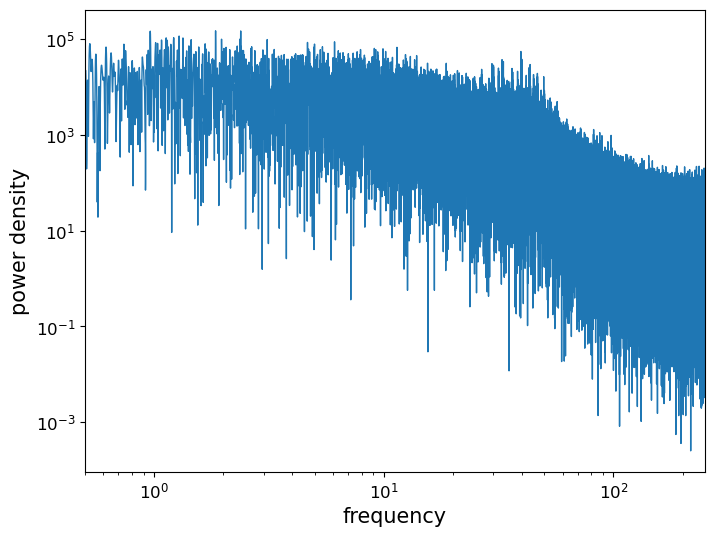

minimization solution: [2.75312812e+04 5.08332658e+00 6.23505051e+03 3.04150594e+01
 1.98071830e+01 1.58312460e+03 4.00697511e+01 6.73634956e+00]
30 8


  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/ccra8514/anaconda3/envs/emcee_env/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ccra8514/anaconda3/envs/emcee_env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1000/1000 [07:18<00:00,  2.28it/s]


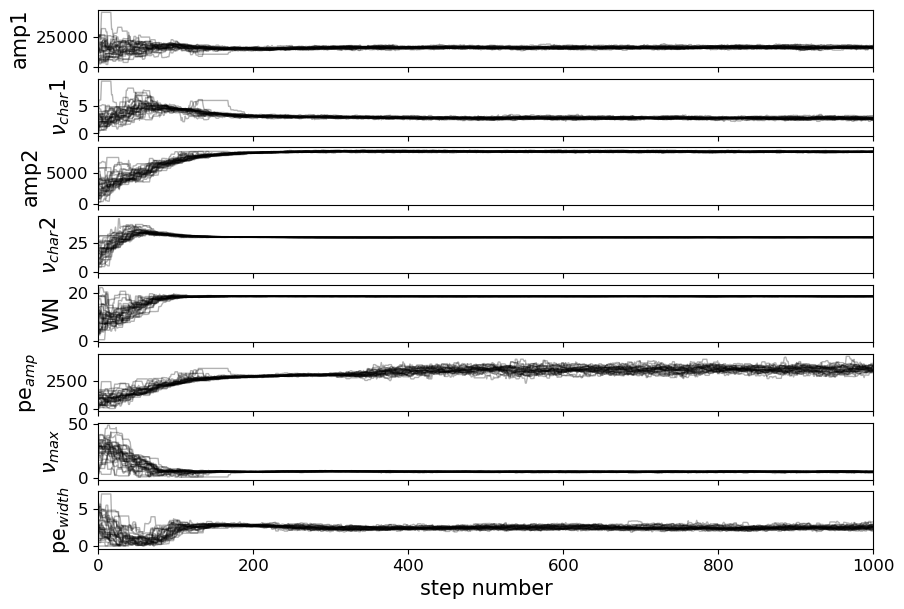

In [137]:
powerspec = pd.read_csv('../data/bgfitting_PSDs/KIC3347458_PS.csv')

powerdensity = powerspec['power']
frequency = powerspec['freq']
powerdensity = powerdensity[frequency>0.5]
frequency = frequency[frequency>0.5]
powerdensity_smooth = convolve(powerdensity, Gaussian1DKernel(100))

plt.plot(frequency,powerdensity)
plt.xlabel('frequency')
plt.ylabel('power density')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.5,250)
plt.show()

pysyd_guess = np.array([27536, 4, 6170, 28, 20, 100, 40, 20])
xmin= np.array([0, 0, 0, 0, 0, 0, 20, 0])
xmax= np.array([1e5,250,1e5,250,1e3,1e6,60,20])
bnds = np.c_[(xmin,xmax)]

minimization_solution = run_initial_minimization(frequency,powerdensity,pysyd_guess,bnds)
print('minimization solution:',minimization_solution.x)

samples,labels,sampler = run_emcee(frequency,powerdensity,minimization_solution.x)

In [ ]:
# samples = sampler.get_chain()
with open('../data/emcee_pickles/KIC3347458.pkl', 'wb') as f:
    pickle.dump(samples, f)
    f.close()

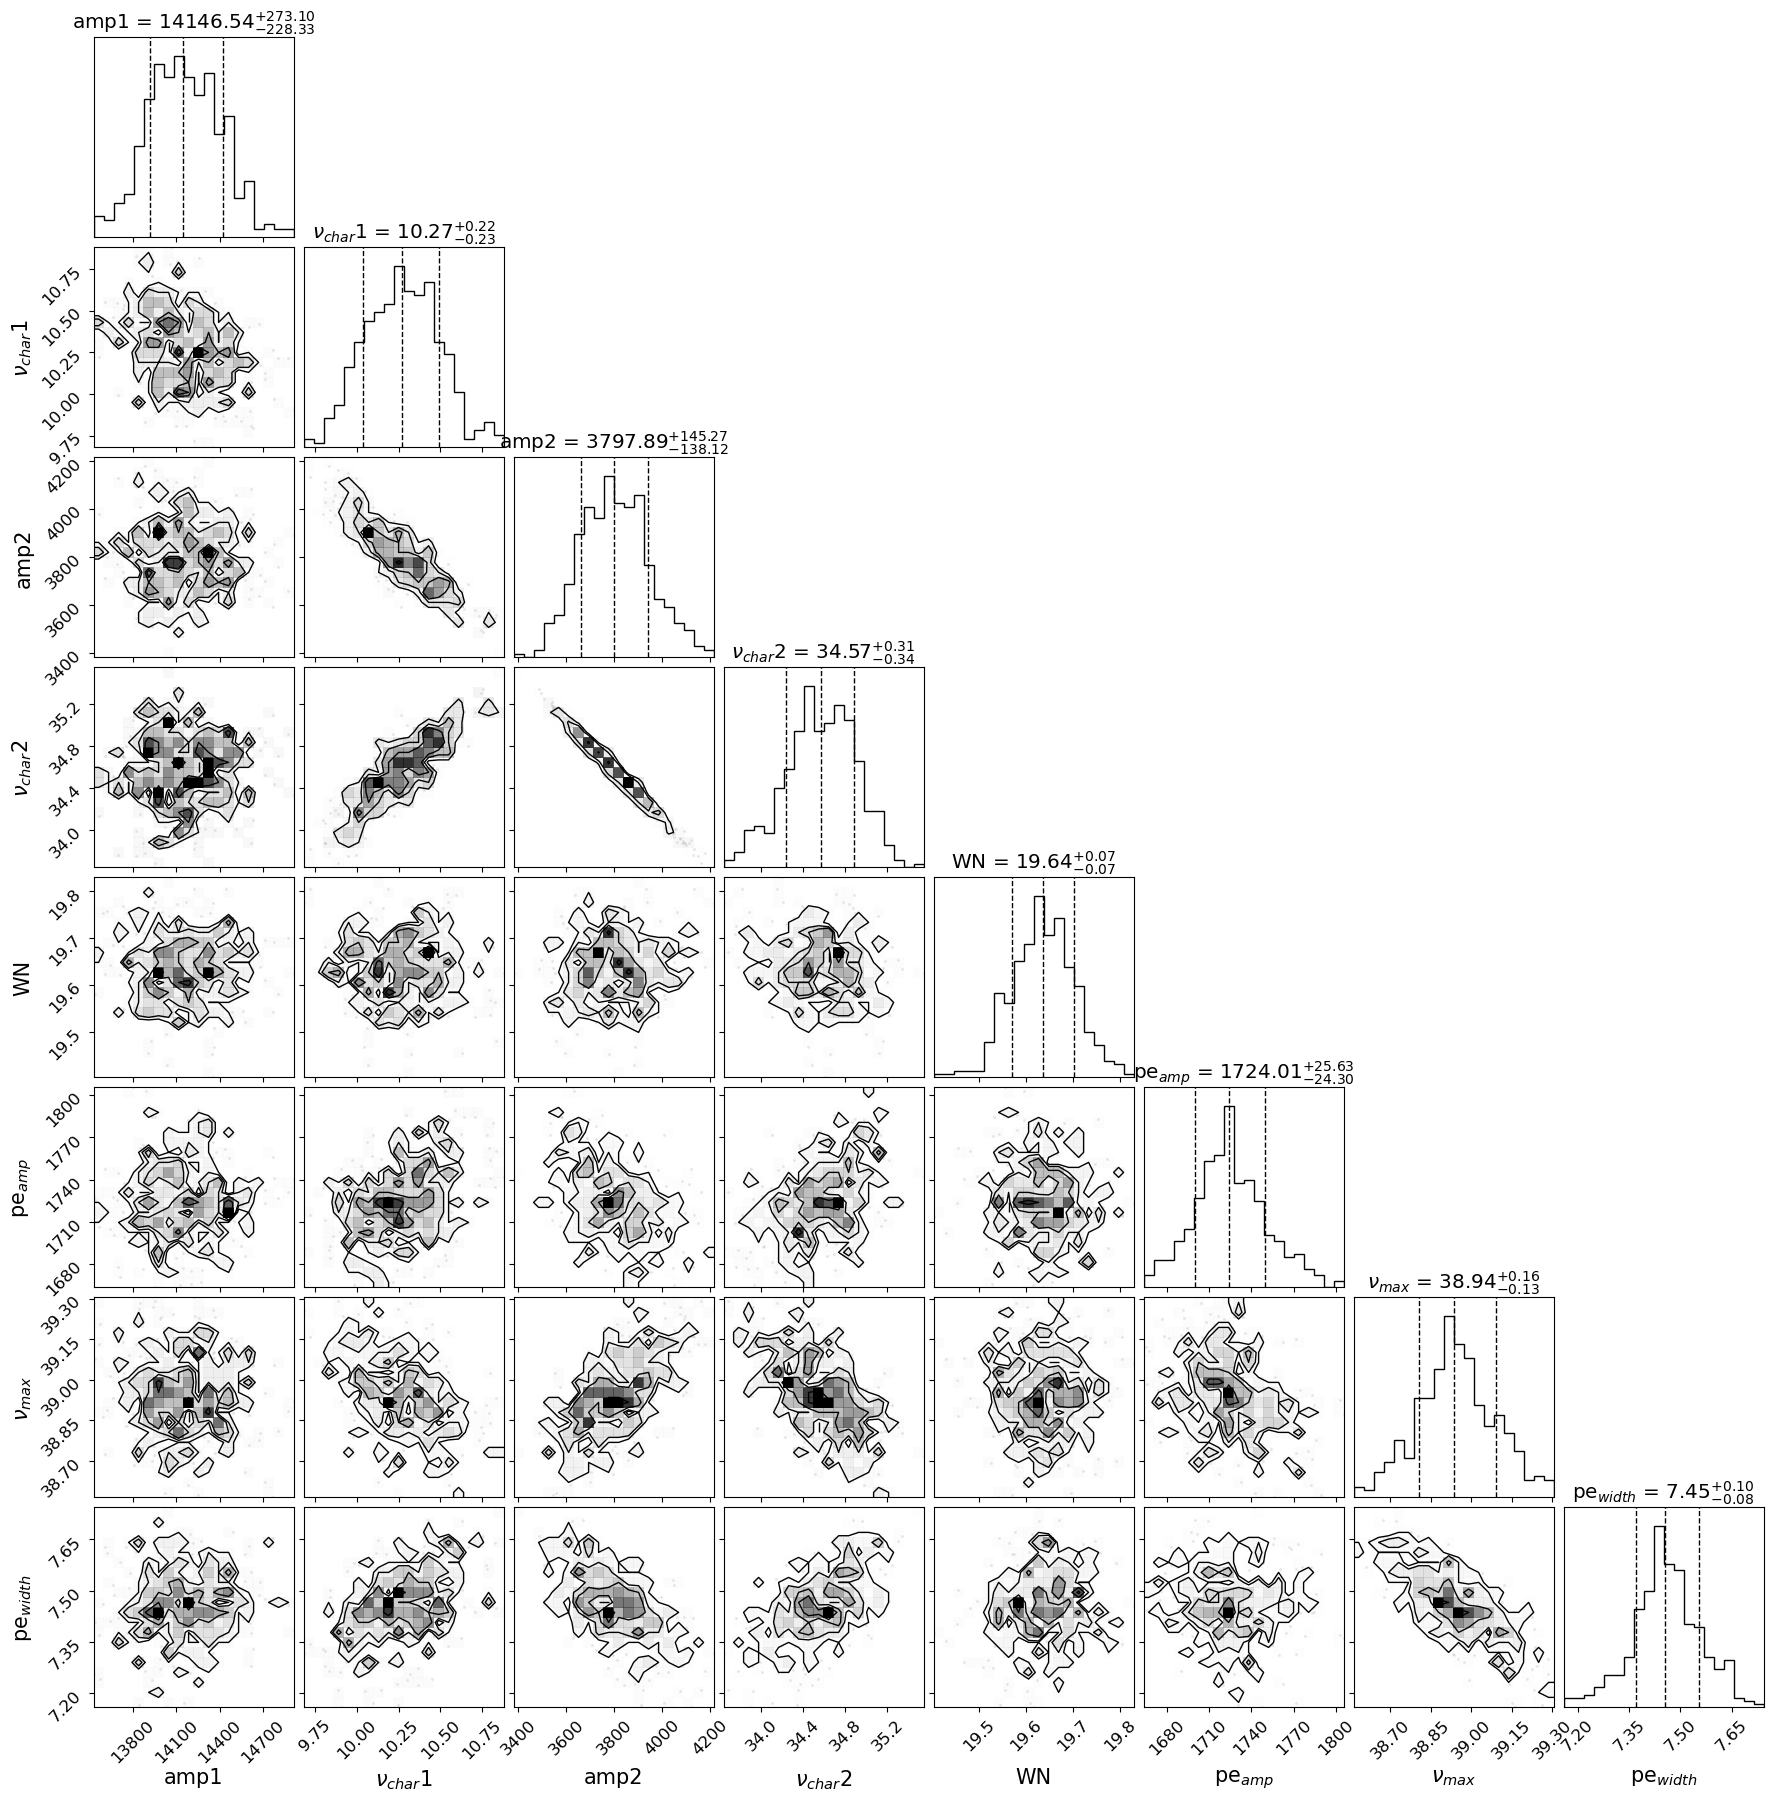

In [144]:
flat_samples = sampler.get_chain(discard=800, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True
);

In [139]:
emcee_soln = []
emcee_errs = []
for i in range(0,len(flat_samples[0])):
    emcee_soln.append(corner.quantile(flat_samples[:,i], 0.5)[0])
    emcee_errs.append(np.average(np.abs(corner.quantile(flat_samples[:,i], [0.16, 0.84])-\
                                        corner.quantile(flat_samples[:,i], 0.5)[0])))
# emcee_soln = flat_samples[-1]
# str_list = np.array(['amp1','nu_char1','amp2','nu_char2','wn','pe_amp','numax','pe_width'])
# emcee_full_soln = np.c_[(emcee_soln,emcee_errs)]
# emcee_df = pd.DataFrame(emcee_full_soln,index=str_list)
# emcee_df.to_csv('../data/emcee_fits/KIC3347458.csv',header=False)

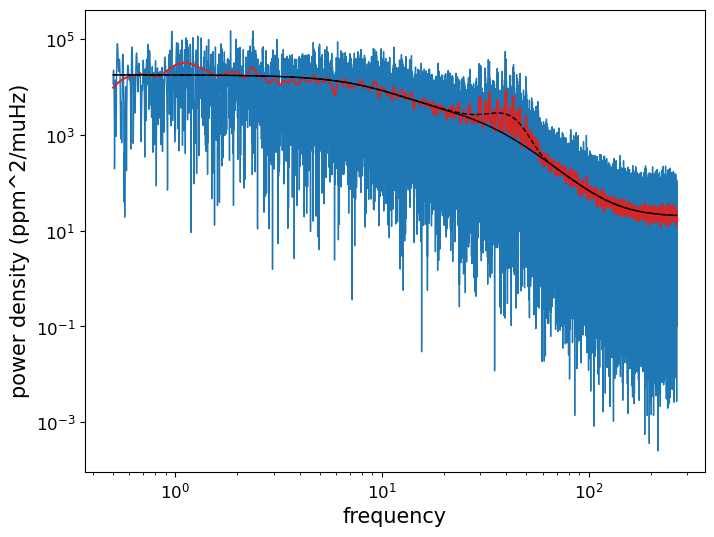

In [140]:
plot_fit(frequency,powerdensity,powerdensity_smooth,emcee_soln,minimization_solution.x)

numax fitted: 38.936379122490315
numax smoothed: 41.62260567294619


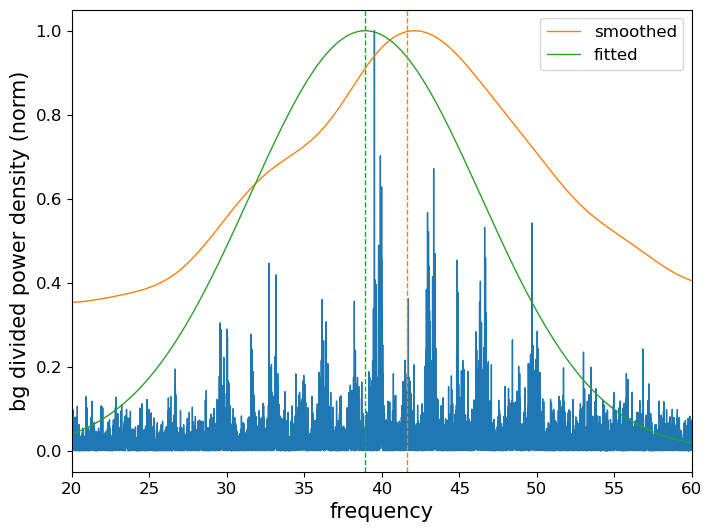

In [141]:
smooth_numax = smooth_numax_fit(frequency,powerdensity,emcee_soln)

In [142]:
# emcee_soln = []
# emcee_errs = []
# for i in range(0,len(flat_samples[0])):
#     emcee_soln.append(corner.quantile(flat_samples[:,i], 0.5)[0])
#     emcee_errs.append(np.average(np.abs(corner.quantile(flat_samples[:,i], [0.16, 0.84])-\
#                                         corner.quantile(flat_samples[:,i], 0.5)[0])))
# emcee_soln.append(frequency[np.argmax(bg_divided_smooth_power)])
# emcee_errs.append(np.NaN)
# # emcee_soln = flat_samples[-1]
# str_list = np.array(['amp1','nu_char1','amp2','nu_char2','wn','pe_amp','numax','pe_width','smooth_numax'])
# emcee_full_soln = np.c_[(emcee_soln,emcee_errs)]
# emcee_df = pd.DataFrame(emcee_full_soln,index=str_list)
# emcee_df.to_csv('../data/emcee_fits/KIC3347458.csv',header=False)
# emcee_df